pip install pandas

pip install rc

pip install seaborn

pip install scikit-learn

# 导入包

In [1]:
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import _utils
#from torch.utils.data import TensorDataset, SequentialSampler, RandomSampler, torch.utils.data.DataLoader
import pandas as pd

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
#常用包
#import rc
import numpy as np 
import pandas as pd 
import openpyxl
import seaborn as sns 
from pylab import rcParams 
import matplotlib.pyplot as plt 
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'#主题

In [3]:
sns.set(style='whitegrid',palette='muted',font_scale=1.2)

#HAPPY_COLORS_PALETTE =["#OIBEFE","#FFDDO0","#FF7D00","#FF006D","#ADFFO2","#8F0OFF"]

sns.set_palette(sns.color_palette())

rcParams['figure.figsize']=12,8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
torch.cuda.is_available()

True

# 2加载数据

In [5]:
#train = pd.read_csv('data/ToGreat/train.csv', sep='\t')#[0:10000]
#test = pd.read_csv('data/ToGreat/test.csv',sep='\t')#[0:1000]
train = pd.read_excel('D:\AI\data\OC_Goods_Classfication\goods_name_classfication_train.xlsx', sheet_name='goods')

# 3.1 数据预处理

In [6]:
# goods_name 空值填充
train.count()

goods_name              452335
outer_category_name          2
site                         2
outer_category_id            2
esc_category_name_cn    452335
esc_category_name_us    452335
esc_category_id         452336
esc_category_tree       373983
dtype: int64

In [7]:
df = train[train['goods_name'] == '']
print(df.count())
print(train['goods_name'].describe())
print(train['goods_name'].count())
#train['goods_name'] = train['goods_name'].fillna('')
#train = train.dropna(subset=['goods_name'])

goods_name              0
outer_category_name     0
site                    0
outer_category_id       0
esc_category_name_cn    0
esc_category_name_us    0
esc_category_id         0
esc_category_tree       0
dtype: int64
count     452335
unique    312869
top        spu测试
freq        2272
Name: goods_name, dtype: object
452335


In [8]:
import re
def preprocess_replace_chinese_test(text):
    cleaned_text = re.sub(r"spu测试", "", text)
    cleaned_text = re.sub(r"CHURANTYe", "", cleaned_text)
    cleaned_text = re.sub(r"CHURANTY", "", cleaned_text)
    return cleaned_text

def preprocess_keep_alphabet(text):
    # 只保留商品名称中的英文字母(大小写)
    cleaned_text = re.sub(r"[^a-zA-Z\s]", "", text)
    return cleaned_text

def preprocess_replace_number(text):
    # 去除商品名称中的数字
    cleaned_text = re.sub(r"\d", "", text)
    return cleaned_text

def preprocess_replace_character(text):
    # 去除商品名称中的特殊字符
    cleaned_text = re.sub(r"[^\w\s]", "", text)
    return cleaned_text

train['goods_name'] = train['goods_name'].astype(str).apply(preprocess_replace_chinese_test)
train['goods_name'] = train['goods_name'].astype(str).apply(preprocess_keep_alphabet)
df = train[train['goods_name'] == '']
print(df.count())

train = train[train['goods_name'].str.strip() != ""]
print(train[train['goods_name'] == ""])
print(train['goods_name'].describe())

goods_name              6292
outer_category_name        0
site                       0
outer_category_id          0
esc_category_name_cn    6292
esc_category_name_us    6292
esc_category_id         6292
esc_category_tree       6249
dtype: int64
Empty DataFrame
Columns: [goods_name, outer_category_name, site, outer_category_id, esc_category_name_cn, esc_category_name_us, esc_category_id, esc_category_tree]
Index: []
count     445228
unique    279872
top            e
freq         472
Name: goods_name, dtype: object


In [9]:
# 大小写转换
# 将商品名称转换为小写
#train['goods_name'] = train['goods_name'].str.lower()

In [10]:
train.head()

,goods_name,outer_category_name,site,outer_category_id,esc_category_name_cn,esc_category_name_us,esc_category_id,esc_category_tree
0,Orisfure,Bed Mattress,eBay,1.926372e+12,沙发,Sofa,904418883006541233,"973693422906821692,476244496307409828,46518752..."
1,nan,Bed Mattress,eBay,1.926372e+12,NaN,NaN,904418883006541233,NaN
2,Drop Dangle Earring for women K Gold Plated Le...,NaN,NaN,NaN,饰品配件,Jewelry Accessories,371877300376083964,"512943444972819177,369769692364539096,77419653..."
4,Sexy suspender nightdress womens summer slim f...,NaN,NaN,NaN,连衣裙,Dress,967713307965910423,"512943444972819177,369603513633719326,36101694..."
5,Black Bride Tribe Canvas Beach Tote Bag,NaN,NaN,NaN,工艺礼品,Handcrafted Gift,214883305443025368,"608643351857857409,376012518892889731,11287720..."


# 3.2 标签转换

In [11]:
#label_id2cate= dict(enumerate(train.categories.unique()))
#label_cate2id = {value:key for key, value in label_id2cate.items()}
#train['label'] = train['categories'].map(label_cate2id)

label_id2cate= dict(enumerate(train.esc_category_id.unique()))
label_cate2id = {value:key for key, value in label_id2cate.items()}
train['label'] = train['esc_category_id'].map(label_cate2id)


In [12]:
print(train['label'].value_counts())

label
7       54225
4       37075
22      23872
2       22065
1       15277
        ...  
1205        1
1141        1
1208        1
1055        1
1210        1
Name: count, Length: 1310, dtype: int64


In [13]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [14]:
train_count = train['esc_category_id'].value_counts()

In [15]:
train = pd.merge(train,train_count,left_on='esc_category_id',right_on='esc_category_id',how='left')
train

,goods_name,outer_category_name,site,outer_category_id,esc_category_name_cn,esc_category_name_us,esc_category_id,esc_category_tree,label,count
0,Orisfure,Bed Mattress,eBay,1.926372e+12,沙发,Sofa,904418883006541233,"973693422906821692,476244496307409828,46518752...",0,4383
1,nan,Bed Mattress,eBay,1.926372e+12,NaN,NaN,904418883006541233,NaN,0,4383
2,Drop Dangle Earring for women K Gold Plated Le...,NaN,NaN,NaN,饰品配件,Jewelry Accessories,371877300376083964,"512943444972819177,369769692364539096,77419653...",1,15277
3,Sexy suspender nightdress womens summer slim f...,NaN,NaN,NaN,连衣裙,Dress,967713307965910423,"512943444972819177,369603513633719326,36101694...",2,22065
4,Black Bride Tribe Canvas Beach Tote Bag,NaN,NaN,NaN,工艺礼品,Handcrafted Gift,214883305443025368,"608643351857857409,376012518892889731,11287720...",3,1400
...,...,...,...,...,...,...,...,...,...,...
445223,Disc Brake Pad Set Dodge Charger,NaN,NaN,NaN,刹车片,Brake Pads,402302104208197633,"965481414737399678,767597773562012047,46915500...",174,543
445224,SYLVAINE DELACOURTE VANILLE VAHINA by SYLVAINE...,NaN,NaN,NaN,其他美妆工具,Other Beauty Tools,772069051211033696,"512943444972819177,464928591647945654,36512715...",4,37075
445225,BVLGARI AU THE BLEU by Bvlgari EAU DE COLOGNE ...,NaN,NaN,NaN,其他美妆工具,Other Beauty Tools,772069051211033696,"512943444972819177,464928591647945654,36512715...",4,37075
445226,VanbowAccent Seating Shell shaped velvet fabri...,NaN,NaN,NaN,餐椅,Dining Chair,172253810376279116,"973693422906821692,476244496307409828,46518752...",33,3433


In [16]:
# 假设features是特征列，labels是目标列

######################## 先欠采样，后过采样

###########欠采样
under_threshold = 10000
train_under_threshold = train[train['count']>=under_threshold]
features = train_under_threshold.drop('label', axis=1)
labels = train_under_threshold['label']
# 创建RandomUnderSampler对象
# 对数据进行欠采样 
# majority把   571286262132847366其它替换没了
# not minority 全部为1了
# not majority 把571286262132847366其它保留，剩下的都是1

under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=55)
# under_sampler = RandomUnderSampler(sampling_strategy={7: 4000, 4: 3000, 22: 2000, 2: 2000, 1: 2000, 28:1000 }, random_state=0)
features_resampled, labels_resampled = under_sampler.fit_resample(features, labels)
# 将欠采样后的特征和目标重新组合成新的DataFrame
train_under = pd.DataFrame(features_resampled, columns=features.columns)
train_under['label'] = labels_resampled

In [17]:

print(train_under['esc_category_id'].value_counts())
print(train_under[train_under['esc_category_id']=='571286262132847366'])

esc_category_id
371877300376083964    14293
967713307965910423    14293
772069051211033696    14293
571286262132847366    14293
962755260484797315    14293
101457586403307689    14293
Name: count, dtype: int64
Empty DataFrame
Columns: [goods_name, outer_category_name, site, outer_category_id, esc_category_name_cn, esc_category_name_us, esc_category_id, esc_category_tree, count, label]
Index: []


In [18]:
###########过采样
# 当少数类别样本数量低于阈值时，进行过采样
over_threshold = 300
train_over_threshold = train[train['count']<=over_threshold]
features = train_over_threshold.drop('label', axis=1)
labels = train_over_threshold['label']
ros = RandomOverSampler(sampling_strategy='not majority',random_state=0)
features_resampled, labels_resampled = ros.fit_resample(features, labels)
# 将过采样后的新特征和目标重新组合成新的数据集
train_over = pd.DataFrame(features_resampled, columns=features.columns)
train_over['label'] = labels_resampled

In [19]:
train_over['esc_category_id'].count()

339963

In [20]:
train_under_threshold['label'].value_counts() # 6

label
7     54225
4     37075
22    23872
2     22065
1     15277
28    14293
Name: count, dtype: int64

In [21]:
#train_over_threshold['label'].value_counts()
train[train['count']<over_threshold]['label'].value_counts()

label
77      299
273     298
186     297
251     290
150     289
       ... 
1208      1
1210      1
1060      1
1212      1
1232      1
Name: count, Length: 1137, dtype: int64

In [22]:
train_over[train_over['esc_category_id']==662634643205313776]

,goods_name,outer_category_name,site,outer_category_id,esc_category_name_cn,esc_category_name_us,esc_category_id,esc_category_tree,count,label
0,Wig Mixed Brown Wavy Hair Length Curly Hair Ch...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
108,Wig Women African Fluffy Small Curly Hair Mix ...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
179,Brown Girl Natural Party False Hair Length All...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
953,Ladies Oblique Short Straight Hair Head Cover Wig,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
964,Womens Wigs Long Straight Hair Internal Curly ...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
...,...,...,...,...,...,...,...,...,...,...
40026,Long Curly Black Hair For Clip Hair Extensions...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
40027,Small Volume Wig Headgear Hightemperature Mate...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
40028,Short Bob Head Both Sides Qi Middle Point Wig ...,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27
40029,Womens Natural Black Long Straight Hair Wig,NaN,NaN,NaN,发片,Hair Piece,662634643205313776,"512943444972819177,369603513633719326,16906351...",153,27


In [23]:
train_mid = train.loc[lambda x: (x['count']>over_threshold) & (x['count']<under_threshold)]

In [24]:
#train = pd.concat([train_under, train_over])
print(pd.concat([train_under, train_mid,train_over])['label'].value_counts())

train = pd.concat([train_under,train_mid, train_over])

label
1       14293
2       14293
4       14293
7       14293
22      14293
        ...  
556       299
557       299
558       299
559       299
1309      299
Name: count, Length: 1310, dtype: int64


In [25]:
label_id2cate

{0: 904418883006541233,
 1: 371877300376083964,
 2: 967713307965910423,
 3: 214883305443025368,
 4: 772069051211033696,
 5: 408272006636946038,
 6: 101818469232882526,
 7: 571286262132847366,
 8: 961492274791414037,
 9: 613169864854436291,
 10: 704053045640647916,
 11: 903928384840680802,
 12: 608885026989818783,
 13: 256647947390152531,
 14: 874435715941725053,
 15: 902227127805693156,
 16: 278002813168843242,
 17: 269243667600355026,
 18: 969303989995341756,
 19: 169169805831768989,
 20: 754714902157516565,
 21: 310877146138219218,
 22: 962755260484797315,
 23: 167543888436441907,
 24: 904353514239779312,
 25: 171642572996559539,
 26: 104593923467966364,
 27: 662634643205313776,
 28: 101457586403307689,
 29: 172010353244007701,
 30: 313280862139669502,
 31: 304951037456754365,
 32: 501632583915018021,
 33: 172253810376279116,
 34: 508768943365683195,
 35: 310707369091478744,
 36: 610584885750745319,
 37: 802596867532401846,
 38: 171397307549647688,
 39: 265609014069864347,
 40: 76330

In [26]:
train['label'].value_counts()

label
1       14293
2       14293
4       14293
7       14293
22      14293
        ...  
556       299
557       299
558       299
559       299
1309      299
Name: count, Length: 1310, dtype: int64

# 4.1 将文本映射为id表示

In [27]:
# 加载bert的分词器 BERT-Base, Multilingual Cased
tokenizer = BertTokenizer.from_pretrained('D:/AI/data/ToGreat/multi_cased_L-12_H-768_A-12/vocab.txt')
# 加载bert模型，这个路径文件夹下有bert_config.json配置文件和model.bin模型权重文件
bert = BertModel.from_pretrained('D:/AI/data/ToGreat/multi_cased_L-12_H-768_A-12/')

C:\Users\yuting\.conda\envs\pytorch_gpu\lib\site-packages\transformers\tokenization_utils_base.py:1727: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
Some weights of the model checkpoint at D:/AI/data/ToGreat/multi_cased_L-12_H-768_A-12/ were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

In [28]:
tokenizer

BertTokenizer(name_or_path='D:/AI/data/ToGreat/multi_cased_L-12_H-768_A-12/vocab.txt', vocab_size=119547, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [29]:
train['goods_name'][5]

5    LOVELY SARAH JESSICA PARKER by Sarah Jessica P...
5    Hinten Luftfederung GN Fr Citroen C Picasso Gr...
Name: goods_name, dtype: object

In [30]:
sample_txt = 'black bride tribe canvas beach tote bag'

In [31]:
tokens = tokenizer.tokenize(sample_txt)
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'文本为：{sample_txt}')
print(f'分词的列表为：{tokens}')
print(f'词对应的唯一id为：{tokens_ids}')

文本为：black bride tribe canvas beach tote bag
分词的列表为：['black', 'br', '##ide', 'tribe', 'can', '##vas', 'beach', 'tot', '##e', 'bag']
词对应的唯一id为：[15045, 33989, 13315, 40964, 10944, 14139, 45405, 10697, 10112, 56332]


# 特殊符号

In [32]:
print(tokenizer.sep_token,tokenizer.sep_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.mask_token,tokenizer.mask_token_id)

[SEP] 102
[UNK] 100
[PAD] 0
[CLS] 101
[MASK] 103


In [33]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=None,
    add_special_tokens=True, # [CLS] 和[SEP]
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt' # pytorch tensor张量
)
encoding.keys()

C:\Users\yuting\.conda\envs\pytorch_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [34]:
encoding

{'input_ids': tensor([[  101, 15045, 33989, 13315, 40964, 10944, 14139, 45405, 10697, 10112,
         56332,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

token ids的长度为25的张量

In [35]:
print(len(encoding['input_ids'][0]))

12


attention_mask具有同样的长度

In [36]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

12


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [37]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'black',
 'br',
 '##ide',
 'tribe',
 'can',
 '##vas',
 'beach',
 'tot',
 '##e',
 'bag',
 '[SEP]']

In [38]:
train.goods_name

112245    Pairs Bar Dangle Earrings with Threader Chain ...
61388     Pcs Stainless Rings for Men Vintage Wide Biker...
338496    Womens Watch Fashion Casual Large Square Mens ...
25692     New Luxury Rose Gold Watch Women Fashion Watch...
206359    Fashion Sleepwear Backless Teddies Hollow Body...
                                ...                        
339958        White Cue Ball Billiard Ball Cue Ball Snooker
339959        White Cue Ball Billiard Ball Cue Ball Snooker
339960        White Cue Ball Billiard Ball Cue Ball Snooker
339961        White Cue Ball Billiard Ball Cue Ball Snooker
339962        White Cue Ball Billiard Ball Cue Ball Snooker
Name: goods_name, Length: 664257, dtype: object

# 4.2 选取商品名称最大长度

token_lens = []
for txt in tqdm(train.goods_name):
    tokens = tokenizer.encode(txt,max_length=512)
    token_lens.append(len(tokens))
    

sns.distplot(token_lens)
plt.xlim([0,256]);
plt.xlabel('Token count');

pd.Series(token_lens).describe() # 25

# 5.构建商品数据集

# 5.1 自定义数据集

In [39]:
class GoodsDataset(Dataset):
    def __init__(self,texts, labels, tokenizer,max_len):
        self.texts=texts
        self.labels=labels 
        self.tokenizer=tokenizer 
        self.max_len=max_len 
    def __len__(self):
        return len(self.texts)
    def __getitem__(self,item):
        '''item 为数据索引，迭代取第item条数据'''
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors= 'pt',
        )
        
        return {
            'texts':text,
            "input_ids":encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }

In [40]:
MAX_LEN=128

# 5.2 划分数据集并创建生成器

In [41]:
df_train,df_test = train_test_split(train,test_size=0.1,random_state=RANDOM_SEED)
df_val,df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)
df_train.shape,df_val.shape,df_test.shape

((597831, 10), (33213, 10), (33213, 10))

In [42]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=GoodsDataset(
    texts=df['goods_name'].values,
    labels=df['label'].values,
    tokenizer=tokenizer,
    max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0, # windows多线程
        pin_memory=True
    )

In [43]:
BATCH_SIZE = 16 #每次8条

train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [44]:
next(iter(train_data_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'texts': ['Halloween Man Shot by Jesus Del Pozo Eau De Toilette Spray  oz',
  'Cycling Sunglasses Polarized Bike Sunglasses Goggles For Men',
  'Smart Card Card Reader Connector Adapter Personal Computer Bank Card ID Card Card Reader',
  'PcsPcs  XH',
  'Mens casual loose straight shorts solid color multipocket pants',
  'Fishing Set Hook Sea Fishing Equipment',
  ' Holder Multi Guitar Folding Stand',
  'LIMIKAHICAFED',
  ' Lshaped Triple Bunk BedTwin over Twin Bunk Bed with Attached Twin Loft Bed and Ladder and Slide Gray',
  'Icepeak Damen Softshelljacke Outdoorjacke Lucy',
  'Kaia Nightstand Two Drawers Metal Handle Light Gray',
  'in DIY Solar Robot Toy STEM Projects Educational Science Experiment Robotic',
  'Earring Cartoon Christmas Gift Tassel Earring Elk Earring',
  'AGR EGR Valve For VW Transporter MK V   For TDI For motion F',
  'Ride on Wiggle Car wLED Flashing Wheels for  Years PinkBlack',
  'Kshioe Softbox Lighting Kit Photo Equipment Studio Softbox  x  with E Socket and

In [45]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [46]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


# 6 基于预训练Bert商品名称分类模型构建

In [47]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [48]:
encoding

{'input_ids': tensor([[  101, 15045, 33989, 13315, 40964, 10944, 14139, 45405, 10697, 10112,
         56332,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [49]:
last_hidden_state,pooled_output = bert(
    input_ids=encoding['input_ids'],
    attention_mask = encoding['attention_mask'],
    return_dict=False
)

In [50]:
last_hidden_state

tensor([[[ 0.1907, -0.1547, -0.2346,  ...,  0.6922, -0.0455,  0.0871],
         [-0.4174,  0.5325,  0.2448,  ...,  1.2708,  0.3384, -0.2460],
         [-0.4611,  0.5111, -0.4659,  ...,  0.5059, -0.0166, -0.6450],
         ...,
         [ 0.2184, -0.3803, -0.0056,  ...,  0.6411, -0.1221, -0.1841],
         [ 0.3260, -0.5206, -0.4867,  ...,  0.9509, -0.3550, -0.0771],
         [ 0.2213, -0.2507, -0.1102,  ...,  0.6592,  0.0423,  0.0850]]],
       grad_fn=<NativeLayerNormBackward0>)

In [51]:
last_hidden_state.shape

torch.Size([1, 12, 768])

一条样本25个token 768维向量

In [52]:
pooled_output.shape
#整句表示

torch.Size([1, 768])

In [53]:
pooled_output

tensor([[ 8.0730e-02, -1.0816e-01,  1.3653e-01, -2.5830e-01, -9.6268e-02,
          1.0993e-01,  2.0044e-01, -6.5314e-02, -2.1456e-01,  8.6116e-03,
         -2.6521e-01,  3.7004e-02,  7.8069e-02,  1.9652e-01,  9.4399e-02,
          1.2559e-01,  2.0349e-01,  1.6820e-01,  4.3018e-01, -2.6069e-01,
         -9.6567e-01, -1.2277e-01,  6.1679e-02, -4.1473e-02,  4.2039e-02,
          2.4008e-01, -2.5149e-01,  1.3551e-01,  1.9105e-01, -2.3839e-01,
          5.2267e-02, -9.7178e-01,  6.6251e-01,  6.7694e-02,  1.3095e-01,
         -2.0447e-01,  1.3126e-01, -5.2130e-02,  1.0550e-01, -8.8672e-02,
         -1.3966e-01,  1.4880e-01, -4.1712e-02,  7.9143e-02,  2.2217e-01,
         -1.8652e-01, -1.3450e-01,  3.2557e-01, -1.0547e-01, -1.1163e-01,
          2.1957e-01, -9.7257e-02,  1.7306e-01,  2.4442e-03, -1.9033e-02,
         -2.7693e-03, -1.6114e-02, -2.2723e-02,  1.3811e-01, -2.8740e-01,
          2.1881e-01,  3.4554e-01,  1.1437e-01, -5.6997e-02, -1.8809e-01,
         -1.3173e-01, -7.3508e-02,  6.

# 定义分类模型

In [54]:
class GoodsClassifier(nn.Module):
    def __init__(self,n_classes):
        super(GoodsClassifier,self).__init__()
        self.bert=BertModel.from_pretrained('D:\AI\data\ToGreat\multi_cased_L-12_H-768_A-12/')
        self.drop=nn.Dropout(p=0.3)
        self.out=nn.Linear(self.bert.config.hidden_size,n_classes)
    
    def forward(self,input_ids,attention_mask):
        _,pooled_output=self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output=self.drop(pooled_output) # dropout
        return self.out(output)

In [55]:
class_names=train.esc_category_id.unique()
class_names

array([371877300376083964, 967713307965910423, 772069051211033696, ...,
       478363797226981898, 767471987759581891, 567582719291335673],
      dtype=int64)

In [56]:
model=GoodsClassifier(len(class_names))
model=model.to(device)

Some weights of the model checkpoint at D:\AI\data\ToGreat\multi_cased_L-12_H-768_A-12/ were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
data

{'texts': ['Halloween Man Shot by Jesus Del Pozo Eau De Toilette Spray  oz',
  'Cycling Sunglasses Polarized Bike Sunglasses Goggles For Men',
  'Smart Card Card Reader Connector Adapter Personal Computer Bank Card ID Card Card Reader',
  'PcsPcs  XH',
  'Mens casual loose straight shorts solid color multipocket pants',
  'Fishing Set Hook Sea Fishing Equipment',
  ' Holder Multi Guitar Folding Stand',
  'LIMIKAHICAFED',
  ' Lshaped Triple Bunk BedTwin over Twin Bunk Bed with Attached Twin Loft Bed and Ladder and Slide Gray',
  'Icepeak Damen Softshelljacke Outdoorjacke Lucy',
  'Kaia Nightstand Two Drawers Metal Handle Light Gray',
  'in DIY Solar Robot Toy STEM Projects Educational Science Experiment Robotic',
  'Earring Cartoon Christmas Gift Tassel Earring Elk Earring',
  'AGR EGR Valve For VW Transporter MK V   For TDI For motion F',
  'Ride on Wiggle Car wLED Flashing Wheels for  Years PinkBlack',
  'Kshioe Softbox Lighting Kit Photo Equipment Studio Softbox  x  with E Socket and

In [58]:
input_ids=data['input_ids'].to(device)
attention_mask=data['attention_mask'].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [59]:
F.softmax(model(input_ids,attention_mask),dim=1)

tensor([[0.0006, 0.0011, 0.0005,  ..., 0.0008, 0.0010, 0.0008],
        [0.0005, 0.0009, 0.0006,  ..., 0.0007, 0.0007, 0.0007],
        [0.0006, 0.0008, 0.0004,  ..., 0.0009, 0.0008, 0.0006],
        ...,
        [0.0007, 0.0010, 0.0006,  ..., 0.0008, 0.0008, 0.0009],
        [0.0005, 0.0011, 0.0006,  ..., 0.0010, 0.0009, 0.0010],
        [0.0006, 0.0010, 0.0005,  ..., 0.0009, 0.0010, 0.0009]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

# 7 模型训练

In [60]:
EPOCHS = 16 # 训练轮数

#optimizer = AdamW(model.parameters(),lr=2e-5,correct_bias=False)
optimizer = AdamW(model.parameters(),lr=3e-5,correct_bias=False)
total_steps=len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\yuting\.conda\envs\pytorch_gpu\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [61]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model=model.train()
    losses=[]
    correct_predictions=0
    for d in tqdm(data_loader):
        input_ids=d['input_ids'].to(device)
        attention_mask=d['attention_mask'].to(device)
        targets=d['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _,preds=torch.max(outputs,dim=1)
        
        loss=loss_fn(outputs,targets)
        
        correct_predictions+=torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.1)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples,np.mean(losses)
        

In [62]:
def eval_model(model,data_loader,loss_fn,device,n_examples):
    model=model.eval() #验证预测模式
    
    losses=[]
    correct_predictions=0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids=d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets=d['labels'].to(device)
            
            outputs=model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            _,preds=torch.max(outputs,dim=1)
            
            loss=loss_fn(outputs,targets)
            
            correct_predictions+=torch.sum(preds==targets)
            losses.append(loss.item())
            
        return correct_predictions.double()/n_examples,np.mean(losses)

In [63]:
history = defaultdict(list) # 记录10轮loss和acc
best_accuracy=0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc,train_loss=train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc,val_loss=eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f'val  loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc>best_accuracy:
        torch.save(model.state_dict(),'best_model_state.bin')
        best_accuracy =val_acc

Epoch 1/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:20<00:00,  6.21it/s]


Train loss 3.620047429152542 accuracy 0.32237705973761815
val  loss 1.676235522766219 accuracy 0.6320115617378737

Epoch 2/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:24<00:00,  6.20it/s]


Train loss 1.0799159859090137 accuracy 0.7432133830463793
val  loss 0.646458350515858 accuracy 0.8322644747538614

Epoch 3/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:21<00:00,  6.21it/s]


Train loss 0.5797651900404985 accuracy 0.8458427214379984
val  loss 0.5191060723680806 accuracy 0.860325776051546

Epoch 4/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:18<00:00,  6.21it/s]


Train loss 0.4467003948074213 accuracy 0.8761723630925797
val  loss 0.4661311824851569 accuracy 0.8772468611688194

Epoch 5/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:21<00:00,  6.20it/s]


Train loss 0.3729586233108676 accuracy 0.8941824696277042
val  loss 0.4417497677066155 accuracy 0.8881160991178153

Epoch 6/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:02<00:00,  6.22it/s]


Train loss 0.3245729515170636 accuracy 0.9070790909136529
val  loss 0.4378335050792054 accuracy 0.8915785987414566

Epoch 7/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:39:41<00:00,  6.25it/s]


Train loss 0.2890740578250284 accuracy 0.917901547427283
val  loss 0.44972102591903723 accuracy 0.8982326197573239

Epoch 8/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:39:57<00:00,  6.23it/s]


Train loss 0.26276354897773163 accuracy 0.9262316607870786
val  loss 0.4672508243263227 accuracy 0.8990154457591907

Epoch 9/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:39:51<00:00,  6.24it/s]


Train loss 0.2435328704795751 accuracy 0.9327050621329439
val  loss 0.48610082314777747 accuracy 0.9016047933038268

Epoch 10/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:19<00:00,  6.21it/s]


Train loss 0.2260635465431668 accuracy 0.9389693742880513
val  loss 0.5089956651625572 accuracy 0.9055791406979194

Epoch 11/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:26<00:00,  6.20it/s]


Train loss 0.21341051138416478 accuracy 0.9432849751852949
val  loss 0.5295121248091935 accuracy 0.9071447927016529

Epoch 12/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:15<00:00,  6.21it/s]


Train loss 0.20013417915629125 accuracy 0.947565449098491
val  loss 0.5528933677509738 accuracy 0.9075663143949658

Epoch 13/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:39:52<00:00,  6.24it/s]


Train loss 0.1889276766434409 accuracy 0.9506649872622865
val  loss 0.5641266661179003 accuracy 0.90849968385873

Epoch 14/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:01<00:00,  6.23it/s]


Train loss 0.178353652617555 accuracy 0.9534266372938172
val  loss 0.5672019115740821 accuracy 0.9088308794749044

Epoch 15/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:00<00:00,  6.23it/s]


Train loss 0.16969718716739754 accuracy 0.9555710560342304
val  loss 0.5782672535885576 accuracy 0.9100051184777045

Epoch 16/16
----------


100%|██████████████████████████████████████████████████████████████████████████| 37365/37365 [1:40:03<00:00,  6.22it/s]


Train loss 0.16233092165795246 accuracy 0.9569610809743891
val  loss 0.5808478872088397 accuracy 0.9103363140938788



In [64]:
history

defaultdict(list,
            {'train_acc': [tensor(0.3224, device='cuda:0', dtype=torch.float64),
              tensor(0.7432, device='cuda:0', dtype=torch.float64),
              tensor(0.8458, device='cuda:0', dtype=torch.float64),
              tensor(0.8762, device='cuda:0', dtype=torch.float64),
              tensor(0.8942, device='cuda:0', dtype=torch.float64),
              tensor(0.9071, device='cuda:0', dtype=torch.float64),
              tensor(0.9179, device='cuda:0', dtype=torch.float64),
              tensor(0.9262, device='cuda:0', dtype=torch.float64),
              tensor(0.9327, device='cuda:0', dtype=torch.float64),
              tensor(0.9390, device='cuda:0', dtype=torch.float64),
              tensor(0.9433, device='cuda:0', dtype=torch.float64),
              tensor(0.9476, device='cuda:0', dtype=torch.float64),
              tensor(0.9507, device='cuda:0', dtype=torch.float64),
              tensor(0.9534, device='cuda:0', dtype=torch.float64),
              ten

In [65]:
history_train_acc = [ i.cpu() for i in history['train_acc']]
history_val_acc = [ i.cpu() for i in history['val_acc']]

print(history_train_acc)
print(history_val_acc)

#.to('cuda').cpu().numpy()

[tensor(0.3224, dtype=torch.float64), tensor(0.7432, dtype=torch.float64), tensor(0.8458, dtype=torch.float64), tensor(0.8762, dtype=torch.float64), tensor(0.8942, dtype=torch.float64), tensor(0.9071, dtype=torch.float64), tensor(0.9179, dtype=torch.float64), tensor(0.9262, dtype=torch.float64), tensor(0.9327, dtype=torch.float64), tensor(0.9390, dtype=torch.float64), tensor(0.9433, dtype=torch.float64), tensor(0.9476, dtype=torch.float64), tensor(0.9507, dtype=torch.float64), tensor(0.9534, dtype=torch.float64), tensor(0.9556, dtype=torch.float64), tensor(0.9570, dtype=torch.float64)]
[tensor(0.6320, dtype=torch.float64), tensor(0.8323, dtype=torch.float64), tensor(0.8603, dtype=torch.float64), tensor(0.8772, dtype=torch.float64), tensor(0.8881, dtype=torch.float64), tensor(0.8916, dtype=torch.float64), tensor(0.8982, dtype=torch.float64), tensor(0.8990, dtype=torch.float64), tensor(0.9016, dtype=torch.float64), tensor(0.9056, dtype=torch.float64), tensor(0.9071, dtype=torch.float64),

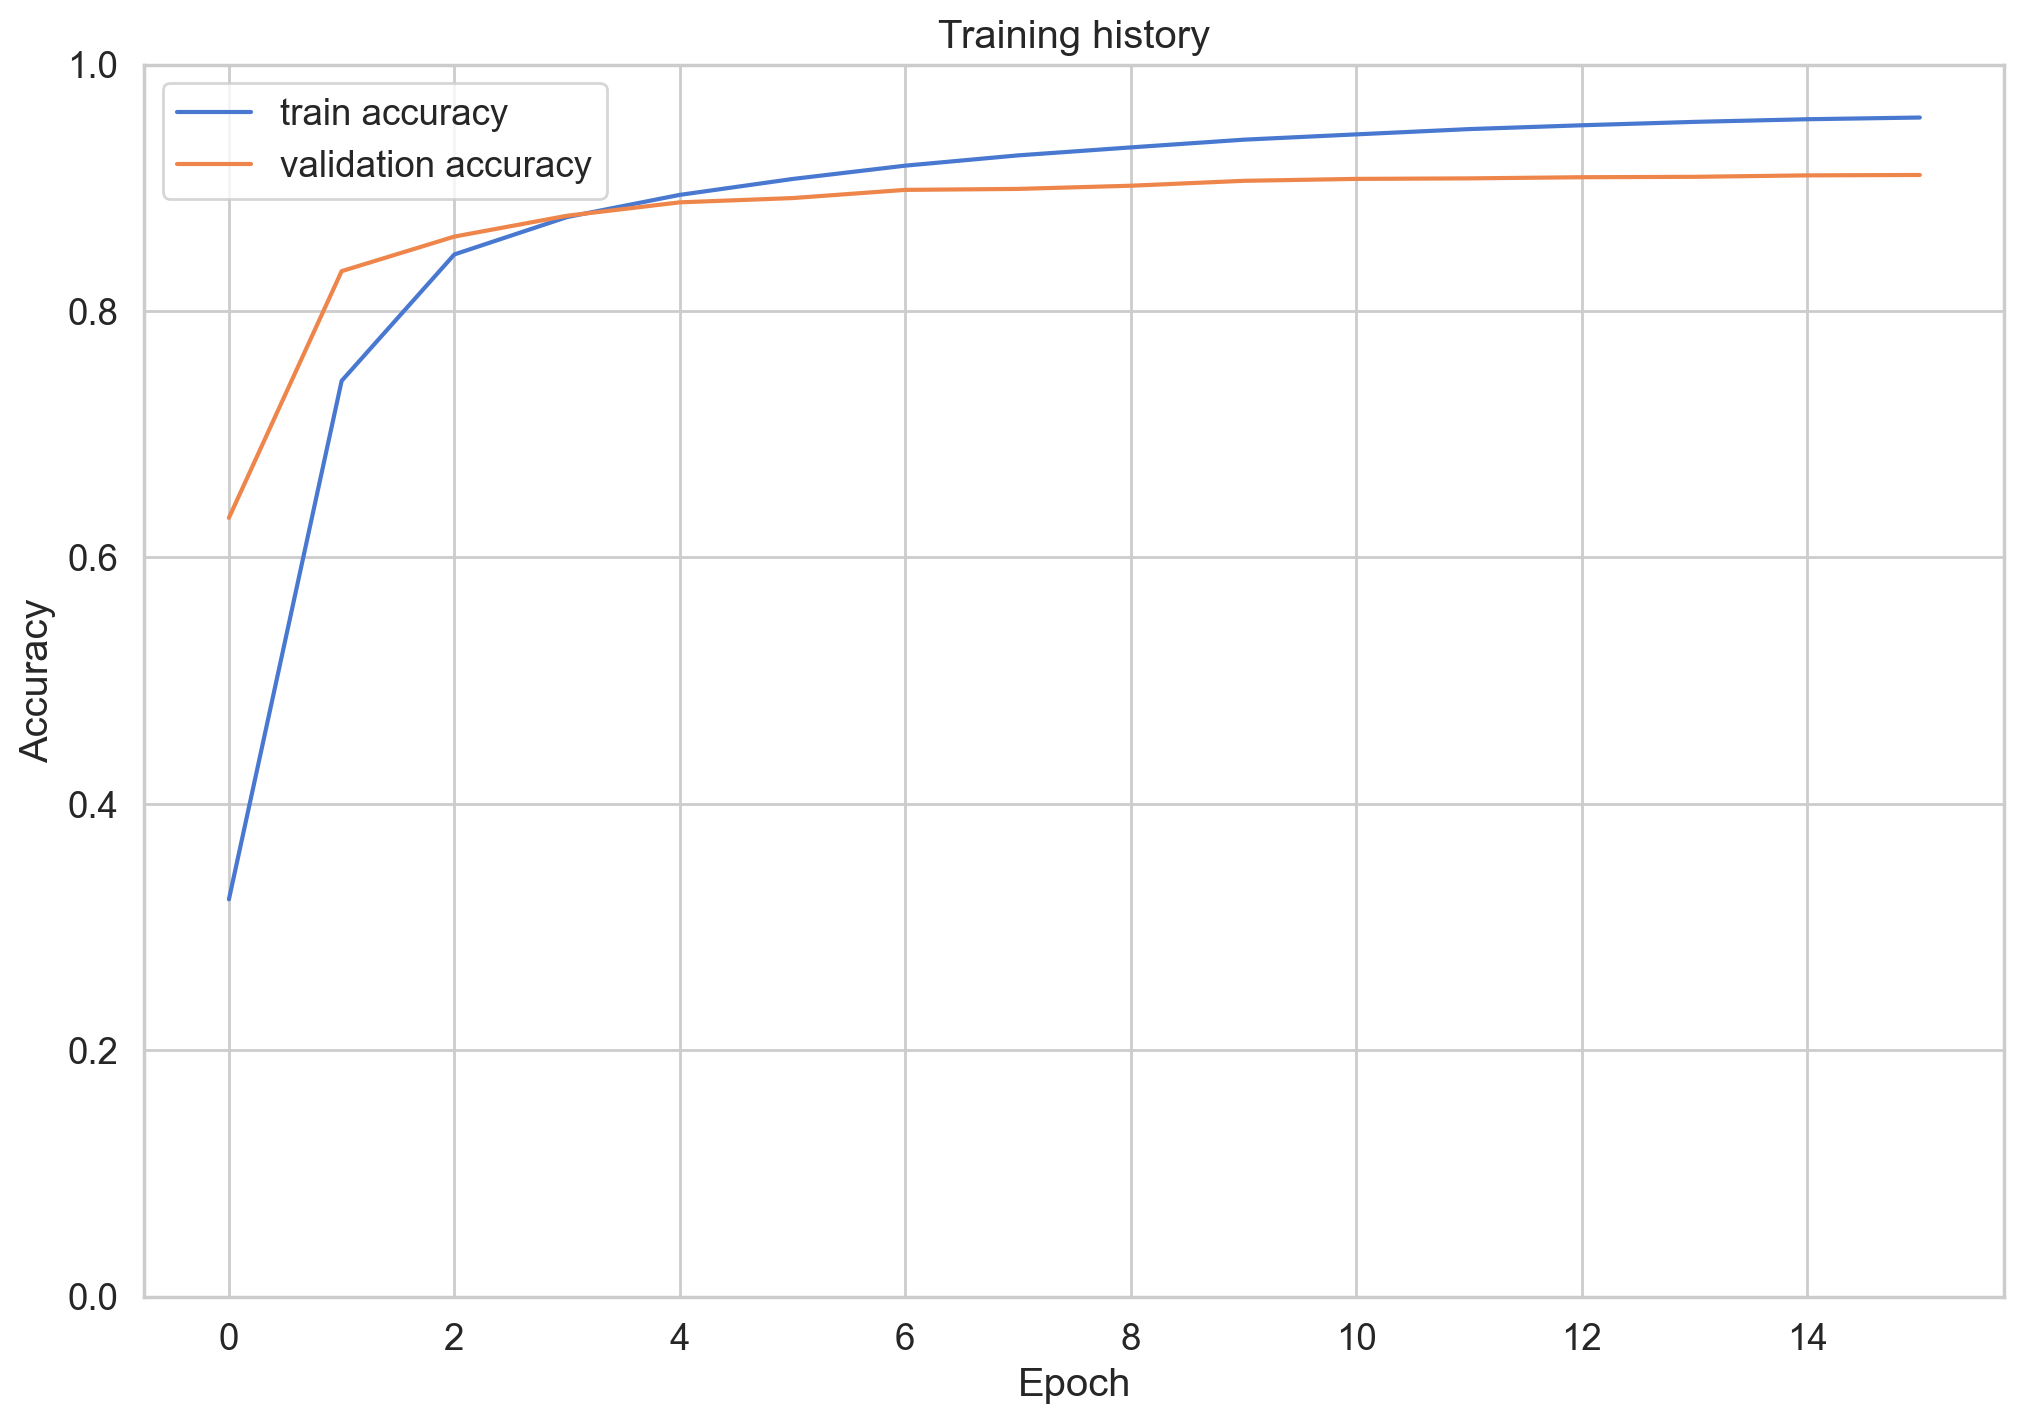

In [66]:
#plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')

plt.plot(history_train_acc, label='train accuracy')
plt.plot(history_val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# 8 模型评估

In [67]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.909854575015807

In [68]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values


In [69]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [70]:
print(y_pred)
print(y_pred.shape)

print(df_test['esc_category_id'].value_counts())



print(y_test)
print(y_test.shape)
print(y_texts)
print(len(y_texts))
label_id2cate
#print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))
#print(classification_report(y_test, y_pred, target_names=[str(label) for label in df_train.label.unique()]))

tensor([ 31, 294, 919,  ...,  22,  28,  23])
torch.Size([33213])
esc_category_id
101457586403307689    764
772069051211033696    715
967713307965910423    708
571286262132847366    705
962755260484797315    692
                     ... 
202158765596373048      6
602173330914826246      6
778185838390964694      6
365348819751003847      5
971951437882855864      5
Name: count, Length: 1310, dtype: int64
tensor([ 31, 294, 919,  ...,  89,   7,  23])
torch.Size([33213])
['Surveillance Tracker Real Time GPS Tracking Device Pocket Size', 'Shampoo Bowl', 'Direct sale autumn and winter plus size mens casual loose straight leg fattening plus black drawstring athleisure trousers', 'Intelligent Audio Sunglasses Wireless Bluetooth  Earphones Protective Glasses Audio Glasses Music Headphones Hands With Microphone Mens', 'Q', 'Baby Girl pc Floral Embroidered Graphic Ruffle Sling Tops  Shorts Sets', 'Liyasi Electric Power Lift Recliner Chair Sofa with Massage and Heat for Elderly  Positions  Side Po

{0: 904418883006541233,
 1: 371877300376083964,
 2: 967713307965910423,
 3: 214883305443025368,
 4: 772069051211033696,
 5: 408272006636946038,
 6: 101818469232882526,
 7: 571286262132847366,
 8: 961492274791414037,
 9: 613169864854436291,
 10: 704053045640647916,
 11: 903928384840680802,
 12: 608885026989818783,
 13: 256647947390152531,
 14: 874435715941725053,
 15: 902227127805693156,
 16: 278002813168843242,
 17: 269243667600355026,
 18: 969303989995341756,
 19: 169169805831768989,
 20: 754714902157516565,
 21: 310877146138219218,
 22: 962755260484797315,
 23: 167543888436441907,
 24: 904353514239779312,
 25: 171642572996559539,
 26: 104593923467966364,
 27: 662634643205313776,
 28: 101457586403307689,
 29: 172010353244007701,
 30: 313280862139669502,
 31: 304951037456754365,
 32: 501632583915018021,
 33: 172253810376279116,
 34: 508768943365683195,
 35: 310707369091478744,
 36: 610584885750745319,
 37: 802596867532401846,
 38: 171397307549647688,
 39: 265609014069864347,
 40: 76330

In [71]:
# 逐个元素比较并输出原先对应的值
for val1, val2, equal in zip(y_pred.tolist(), y_test.tolist(), torch.eq(y_pred, y_test).tolist()):
    print(f"{label_id2cate.get(val1)} is equal to {label_id2cate.get(val2)}: {equal}")

304951037456754365 is equal to 304951037456754365: True
304219012340155545 is equal to 304219012340155545: True
808527692679061463 is equal to 808527692679061463: True
604286246338027431 is equal to 604286246338027431: True
471657369249554866 is equal to 471657369249554866: True
613169864854436291 is equal to 962755260484797315: False
876368549534965019 is equal to 876368549534965019: True
667120536934285745 is equal to 667120536934285745: True
265167459023039734 is equal to 265167459023039734: True
165784066994916413 is equal to 165784066994916413: True
971781659147881327 is equal to 971781659147881327: True
774484243225838388 is equal to 774484243225838388: True
669976195709097293 is equal to 669976195709097293: True
501632583915018021 is equal to 501632583915018021: True
501817064473408073 is equal to 501817064473408073: True
269833529009364182 is equal to 269833529009364182: True
959130929165218108 is equal to 964930456484479717: False
678050209540970073 is equal to 678050209540970

In [72]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
#df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm = pd.DataFrame(cm, index=df_test.categories.unique(), columns=df_test.categories.unique())
show_confusion_matrix(df_cm)

AttributeError: 'DataFrame' object has no attribute 'categories'

# 9 模型预测

In [ ]:
sample_text='Hard but Robust, Easy but Sensitive: How Encod.'
encoded_text = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {label_id2cate[prediction.cpu().numpy()[0]]}')